In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-iq16cq78
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-iq16cq78
  Resolved https://github.com/facebookresearch/detectron2.git to commit 3c7bb714795edc7a96c9a1a6dd83663ecd293e36


In [19]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0
torch:  1.12 ; cuda:  bd13bc6
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import matplotlib.pyplot as plt

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow
from PIL import Image

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

[05/28 15:10:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [49]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

'''
def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {} 
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")
'''

def get_food_dicts(data_dir):
  label_imgs = os.listdir("combinedsegmentationmodel/" + data_dir + "labels")
  #print(label_imgs)
  dataset_dicts = []
  for idx, file_name in enumerate(label_imgs):
      if(idx > 1):
          break
      record = {}
      file_name = file_name.replace(".png", ".jpg")
      record["file_name"] = "/content/combinedsegmentationmodel/" + data_dir + "images/" + file_name
      record["image_id"] = idx
      height, width = cv2.imread(record["file_name"]).shape[:2]
      record["height"] = height
      record["width"] = width

      mask_file_name = "/content/combinedsegmentationmodel/" + data_dir + "labels/" + file_name
      mask_file_name = mask_file_name.replace(".jpg", ".png")
      #img = np.array(Image.open("combinedsegmentationmodel/traininglabels/0.png"))
      #print(record["file_name"])
      #print(mask_file_name)
      #print("debug1")
      img = np.array(Image.open(mask_file_name))
      #print(np.array(Image.open(record["file_name"])).shape)
      #print(img.shape)
      mask_pixels = np.argwhere(img[:,:,2] == 1)
      print(mask_pixels)
      px = [x for x,y in mask_pixels]
      py = [y for x,y in mask_pixels]
      poly = [(x, y) for x, y in zip(px, py)]
      poly = [p for x in poly for p in x]
      objs = []
      obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
      objs.append(obj)
      record["annotations"] = objs
      dataset_dicts.append(record)
      print(obj["segmentation"])
  return dataset_dicts

def get_foodSV_dicts(data_dir):
  img_dir = "/home/jalellcf/Project/FoodSV"
  img_dir = img_dir + "/" + data_dir + "images"
  json_file = os.path.join(img_dir, "all_vertices_" + data_dir + ".json")
  with open(json_file) as f:
      imgs_anns = json.load(f)
      dataset_dicts = []
      for idx, v in enumerate(imgs_anns):
          record = {}
          filename = os.path.join(img_dir, v["External ID"])
          height, width = cv2.imread(filename).shape[:2]
          record["file_name"] = filename
          record["image_id"] = idx
          record["height"] = height
          record["width"] = width
          objs = []
          anno = v["Label"]
          anno = anno["objects"]
          for a in anno:
              poly = [coord for point in a["polygon"] for coord in point.values()]
              px = [point["x"] for point in a["polygon"]]
              py = [point["y"] for point in a["polygon"]]
              #print(flat_list)
              obj = {
                  "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                  "bbox_mode": BoxMode.XYXY_ABS,
                  "segmentation": [poly],
                  "category_id": 0,
              }
              objs.append(obj)
          record["annotations"] = objs
          dataset_dicts.append(record)
  return dataset_dicts

def get_foodseg_dicts(data_dir):
  img_dir = "/content/drive/MyDrive/UNI/TFL902/"
  #img_dir = img_dir + "/" + data_dir + "images"
  json_file = os.path.join(img_dir,  "all_vertices_" + data_dir + ".json")
  with open(json_file) as f:
      imgs_anns = json.load(f)
      dataset_dicts = []
      for idx, v in enumerate(imgs_anns):
          record = {}
          file_name = v["filename"]
          record["file_name"] = "/content/combinedsegmentationmodel/" + data_dir + "images/" + file_name
          record["file_name"] = record["file_name"].replace(".png", ".jpg")
          record["image_id"] = idx
          height, width = cv2.imread(record["file_name"]).shape[:2]
          record["height"] = height
          record["width"] = width
          objs = []
          anno = v["vertices"]  
          #print(anno)

          ###### json does not yet reflect multiple annotations (only one segmentation element in each pic) ######     
          ###### for a in anno:
          poly = [item for sublist in anno for item in sublist]
          #poly = [coord for point in a["polygon"] for coord in point.values()]
          px = [t[0] for t in anno]
          py = [t[1] for t in anno]
          #print(poly)
          obj = {
              "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
              "bbox_mode": BoxMode.XYXY_ABS,
              "segmentation": [poly],
              "category_id": 0,
          }
          objs.append(obj)
          record["annotations"] = objs
          dataset_dicts.append(record)
  return dataset_dicts

food_classes = ["rice", "bean", "boiled egg", "fried egg", 
                  "salad", "steak", "apple", "chicken breast", "lunch",
                  "spaghetti"]

food_classes = ["food"]


def get_myfood_dicts(data_dir):
  img_dir = "/home/jalellcf/Project/MyFood"
  #img_dir = img_dir + "/" + data_dir + "images"
  #print(os.getcwd())
  json_file = os.path.join(img_dir, "myfood_region_" + data_dir + ".json")
  with open(json_file) as f:
      imgs_anns = json.load(f)
      dataset_dicts = []
      for idx, v in enumerate(imgs_anns):
          record = {}
          file_name = v["filename"]
          record["file_name"] = img_dir + "/" + data_dir + "/" + file_name
          labels = []
          if(os.path.isfile(record["file_name"])):
              #print(record["file_name"])
              #record["file_name"] = record["file_name"].replace(".png", ".jpg")
              record["image_id"] = idx
              height, width = cv2.imread(record["file_name"]).shape[:2]
              record["height"] = height
              record["width"] = width
              objs = []
              anno = v["vertices"]  
              #print(anno)

              ###### json does not yet reflect multiple annotations (only one segmentation element in each pic) ######     
              ###### for a in anno:
              poly = [item for sublist in anno for item in sublist]
              #poly = [coord for point in a["polygon"] for coord in point.values()]
              px = [t[0] for t in anno]
              py = [t[1] for t in anno]
              #print(poly)
              #print('_'.join(file_name.split("_")[:-1]).replace("_", " "))
              obj = {
                  "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                  "bbox_mode": BoxMode.XYXY_ABS,
                  "segmentation": [poly],
                  "category_id": 0,
                  #"category_id": food_classes.index('_'.join(file_name.split("_")[:-1]).replace("_", " ")),
              }
              record["label"] = v["class"]
              if(v["class"] == "fried"):
                record["label"] = "fried egg"
              objs.append(obj)
              record["annotations"] = objs
              dataset_dicts.append(record)
  return dataset_dicts


sample_food_classes = ["rice", "pasta", "bread", "cheese", "cereal"]


def get_foodSV_sample_dicts(data_dir):
  img_dir = "/home/jalellcf/Project/foodSV_sample"
  json_file = os.path.join(img_dir, "calories_training_validation.json")
  with open(json_file) as f:
      imgs_anns = json.load(f)
      dataset_dicts = []
      for idx, v in enumerate(imgs_anns):
          #print(v["Label"]["objects"][0]["polygon"])
          #print(v["External ID"])
          #print(v["Dataset Name"].split("_")[0])
          if(v["Dataset Name"].split("_")[0] == data_dir):
              record = {}
              file_name = v["External ID"]
              record["file_name"] = img_dir + "/" + data_dir + "/" + file_name
              if(os.path.isfile(record["file_name"])):
                  #print(record["file_name"])
                  record["image_id"] = idx
                  height, width = cv2.imread(record["file_name"]).shape[:2]
                  record["height"] = height
                  record["width"] = width
                  objs = []
                  anno = v["Label"]["objects"] 
                  #print(anno)
                  i = 0
                  for a in anno:
                      poly_list = a["polygon"]
                      poly = [val for item in poly_list for val in [item['x'], item['y']]]
                      px = [point['x'] for point in poly_list]
                      py = [point['y'] for point in poly_list]
                      #print(poly)
                      #print(px)
                      #print(py)
                      obj = {
                          "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                          "bbox_mode": BoxMode.XYXY_ABS,
                          "segmentation": [poly],
                          #"category_id": 1,
                          "category_id": sample_food_classes.index(v["Label"]["classifications"][i]["answer"]["value"]),
                      }
                      objs.append(obj)
                      #print(sample_food_classes.index(v["Label"]["classifications"][i]["answer"]["value"]))
                      i += 1
                  record["annotations"] = objs
                  dataset_dicts.append(record)
  return dataset_dicts

if "food_training" in DatasetCatalog.list():
  DatasetCatalog.remove("food_training")
  MetadataCatalog.remove("food_training")
    
if "food_validation" in DatasetCatalog.list():
  DatasetCatalog.remove("food_validation")
  MetadataCatalog.remove("food_validation")
    
for d in ["training", "validation"]:
  DatasetCatalog.register("food_" + d, lambda d=d: get_myfood_dicts(d))
  if "food_training" in DatasetCatalog.list():
        #MetadataCatalog.remove("food_training")
        pass
  MetadataCatalog.get("food_" + d).set(thing_classes=food_classes)
  #MetadataCatalog.get("food_" + d).set(thing_classes=food_classes)
  #MetadataCatalog.get("food_" + d).set(thing_classes=["food"])

#MetadataCatalog.remove("food_training")
food_metadata = MetadataCatalog.get("food_training")
print(food_metadata)
#print(food_metadata.get("thing_classes"))



Metadata(name='food_training', thing_classes=['food'])


/home/jalellcf/Project/MyFood/training/spaghetti_26.png
spaghetti


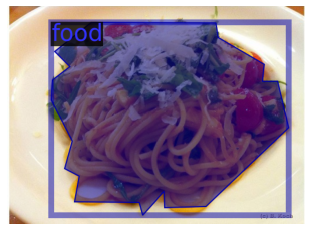

/home/jalellcf/Project/MyFood/training/salad_45.png
salad


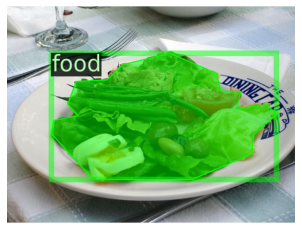

/home/jalellcf/Project/MyFood/training/boiled_egg_43.png
boiled


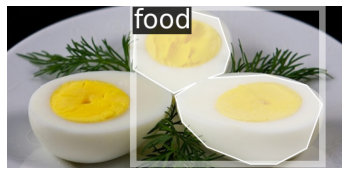

/home/jalellcf/Project/MyFood/training/bean_99.png
bean


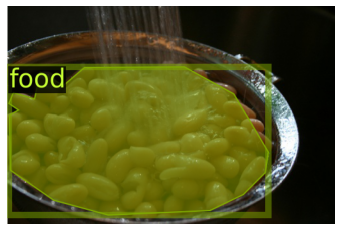

/home/jalellcf/Project/MyFood/training/steak_72.png
steak


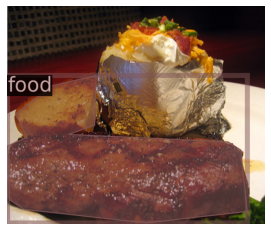

/home/jalellcf/Project/MyFood/training/salad_68.png
salad


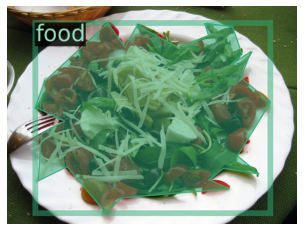

/home/jalellcf/Project/MyFood/training/steak_1.png
steak


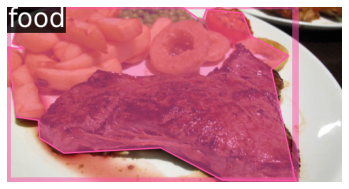

/home/jalellcf/Project/MyFood/training/boiled_egg_54.png
boiled


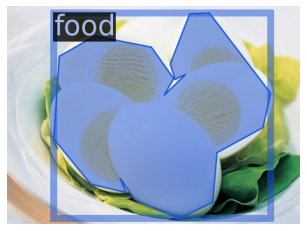

/home/jalellcf/Project/MyFood/training/boiled_egg_76.png
boiled


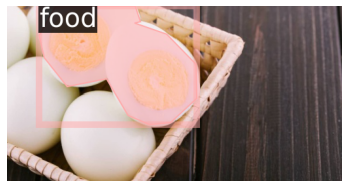

/home/jalellcf/Project/MyFood/training/chicken_breast_28.png
chicken


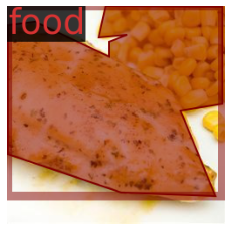

/home/jalellcf/Project/MyFood/training/rice_17.png
rice


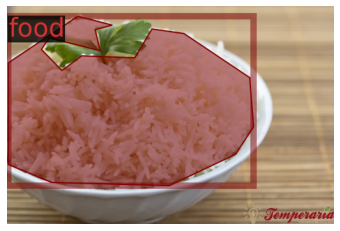

/home/jalellcf/Project/MyFood/training/steak_90.png
steak


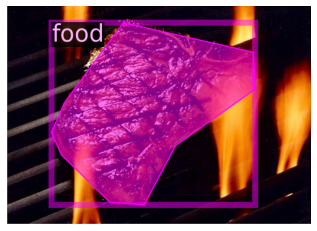

/home/jalellcf/Project/MyFood/training/spaghetti_61.png
spaghetti


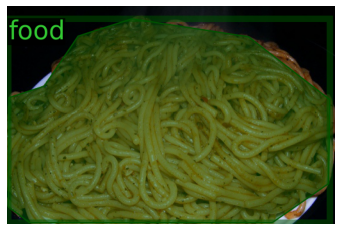

/home/jalellcf/Project/MyFood/training/chicken_breast_1.png
chicken


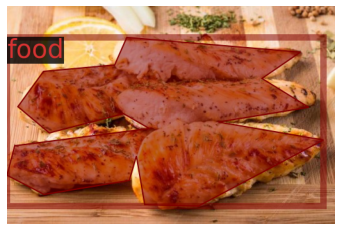

/home/jalellcf/Project/MyFood/training/fried_egg_45.png
fried egg


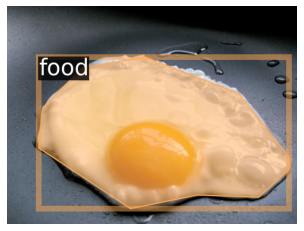

In [50]:
dataset_dicts = get_myfood_dicts("training")
#dataset_dicts = get_foodSV_sample_dicts("validation")



for d in random.sample(dataset_dicts, 15):
    #img = cv2.imread(d["file_name"])
    img = cv2.imread(d["file_name"], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert to BGR color space
    print(d["file_name"])
    print(d["label"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=food_metadata, scale=1)
    visualizer._default_font_size = 40
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()


In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("food_training",)
cfg.DATASETS.TEST = ("food_validation",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 20    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

cfg.OUTPUT_DIR = "./output_myfood_detection"


class CustomTrainer(DefaultTrainer):
    def __init__(self, cfg):
        super().__init__(cfg)

    def train(self):
        data_loader = self.build_train_loader(self.cfg)
        test_data_loader = self.build_test_loader(self.cfg, self.cfg.DATASETS.TEST[0])

        for data_iter, data in enumerate(data_loader, self.start_iter):
            # Training code here
            
            if self.cfg.TEST.EVAL_PERIOD > 0 and (data_iter + 1) % self.cfg.TEST.EVAL_PERIOD == 0:
                # Compute and print loss for the test dataset
                with torch.no_grad():
                    test_losses = self._last_eval_results.get("losses", {})
                    test_loss_str = ", ".join([f"{k}: {v:.4f}" for k, v in test_losses.items()])
                    self._last_eval_results.clear()
                self._last_eval_results["iteration"] = data_iter
                self._last_eval_results["losses"] = test_losses

                # Print the test loss values
                print(f"Test Losses - Iteration {data_iter}: {test_loss_str}")

            # More training code here

        self._last_eval_results = {}


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CustomTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/06 22:16:24 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (11, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (11,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (40, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (40,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (10, 256, 1, 

In [36]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[06/06 14:54:38 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


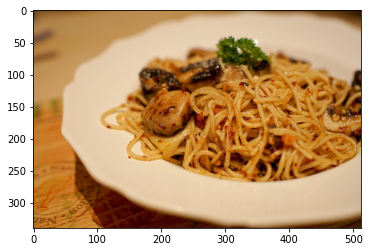

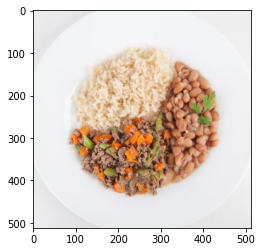

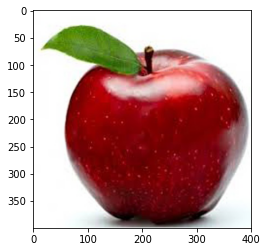

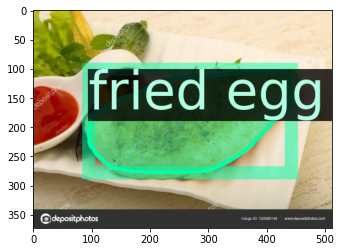

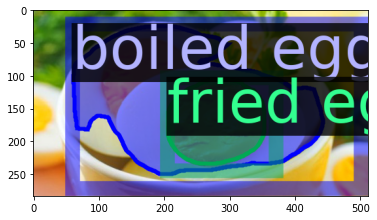

'\n# Convert labels to numpy arrays\ntrue_labels = np.array(true_labels)\npredicted_labels = np.array(predicted_labels)\n#print(predicted_labels)\n# Build confusion matrix\ncm = confusion_matrix(true_labels, predicted_labels)\n\n# Print confusion matrix\nprint("Confusion Matrix:")\nprint(cm)\n\n# Create a figure and axes\nplt.figure(figsize=(10, 8))\nax = plt.subplot()\n\n# Create the heatmap using Seaborn\nsb.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)\n\n# Set labels, title, and ticks\nax.set_xlabel(\'Predicted labels\')\nax.set_ylabel(\'True labels\')\nax.set_title(\'Confusion Matrix\')\nax.xaxis.set_ticklabels(food_classes, rotation=90)\nax.yaxis.set_ticklabels(food_classes, rotation=0)\n\n# Show the plot\nplt.imshow()\n'

In [39]:
from detectron2.utils.visualizer import ColorMode
from sklearn.metrics import confusion_matrix
import seaborn as sb
dataset_dicts = get_myfood_dicts("validation")

true_labels = []
predicted_labels = []

for d in random.sample(dataset_dicts, 5):
#for d in dataset_dicts:
    #im = cv2.imread(d["file_name"])
    im = cv2.imread(d["file_name"], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)  # Convert to BGR color space
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    mask_tensor = outputs["instances"].pred_masks
    num_true = torch.sum(mask_tensor)
    num_false = mask_tensor.numel() - num_true
    #print(num_true)
    #print(num_false)
    #print(mask_tensor.numel())
    #if(num_true.item() != 0):
    #    print(str(round((num_true.item()/mask_tensor.numel())*100, 2)) + "% of the image is food")
    v = Visualizer(im[:, :, ::-1],
                   metadata=food_metadata, 
                   scale=1.0, 
                   instance_mode=ColorMode.IMAGE
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    v._default_font_size = 90
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #print("original:")
    #plt.imshow(im)
    #plt.show()
    #print("prediction:")
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()
    
    #####
    instances = outputs["instances"]
    predicted_classes = instances.pred_classes.tolist()
    #print(predicted_classes)
    
    true_label = d["label"]
    true_labels.append(true_label)
    
    if(predicted_classes):
        predicted_class = food_metadata.thing_classes[predicted_classes[0]]
        predicted_labels.append(predicted_class)
        #predicted_labels.append(predicted_classes[0])
        #print(predicted_class)
    else:
        predicted_labels.append("None")
        
#print(true_labels)
#print(predicted_labels)
'''
# Convert labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
#print(predicted_labels)
# Build confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Create a figure and axes
plt.figure(figsize=(10, 8))
ax = plt.subplot()

# Create the heatmap using Seaborn
sb.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(food_classes, rotation=90)
ax.yaxis.set_ticklabels(food_classes, rotation=0)

# Show the plot
plt.imshow()
'''